In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm
import scipy
import scipy.sparse as spa
!pip install cvxpy
import cvxpy as cp

In [2]:
n_samples = 80
n = 3*n_samples
C = 1

In [3]:
def gaussian_ker(x,y,q):
    """a function to compute the gaussian kernel of two points
    -------------------------------
    inputs : 

    x : array-like, vector
    first vector for which we want to compute the kernel

    y : array-like, vector
    second vector for which we want to compute the kernel

    q : positive float,
    value of the bandwidth of the kernel

    returns:
    ker : float,
    the value of the kernel
    -------------------------------
    """

    ker = np.exp(-q*np.linalg.norm(x-y)**2)
    return ker

In [4]:
def gram_mat(X,q):
    """
    a function to compute the gram matrix of a given dataset

    ----------------------------------------
    inputs : 
    X : array-like object, must be 2D
    the data for which we want to compute the gram matrix

    q : positive float, 
    the bandwidth of the gaussian kernel
    -----------------------------------------

    returns:
    K : the gram matrix
    """
    
    norms = np.linalg.norm(X, axis=1)**2
    dot = X@X.T
    squared_euclidian_distances = norms[:, None] - 2 * dot + norms[None, :]
    K = np.exp(-squared_euclidian_distances*q)
    return K

In [5]:
def compute_seg(x,y,nb=20):
    """
    a function used to compute the segment between two points
    -----------------------------------
    Parameters : 

    x : array-like obj,
    an input, d>=2

    y : array-like obj, 
    the second input

    nb : int, 
    the number of points we want to have between the two points

    Returns : 

    segment : array-like
    an array of shape d (dimension of x), nb
    ---------------------------------------
    """
    d = x.shape[0]
    segment = np.zeros((nb,d))
    points = np.linspace(start=0.,stop=1.,num=nb,endpoint=True)
    for i in range(nb):
        t = points[i]
        segment[i,:] = (1-t)*x + t*y
        
    return segment

In [6]:
def radius(x,sample,beta,bkb,ker_self=1.):
    """
    compute the radius for a given instance x
    -----------------------------------------------
    Parameters : 

    x : 1-D vector,
    the input vector

    sample : matrix, 
    the whole sample, 

    beta : array-like, 
    the calculated beta

    bkb : float,
    the result of beta.T@K@beta

    ker_self : float,
    the value of the kernel of the selected instance with itself, 
    set to 1 by default as we use mostly the gaussian kernel

    returns :

    radius : float,
    the distance between the test instance and the center of the 
    sphere enclosing all the points in the Hilbert space
    -----------------------------------------------
    """
    nb_samp = sample.shape[0]
    temp_k = np.zeros(nb_samp)

    for elem in range(nb_samp):
        temp_k[elem] = gaussian_ker(x,sample[elem],q=48)
        
    return np.sqrt(ker_self - 2*np.dot(temp_k,beta) + bkb)

In [7]:
x_axis_a = np.linspace(-1.,0.8,n_samples,endpoint=True).reshape(-1,1)
x_axis_b = np.linspace(-0.2,1,n_samples,endpoint=True).reshape(-1,1)

cov_noise = np.eye(2)*0.005
cov_noise[1,1] *= 25

gaussian_noise = np.random.multivariate_normal(mean=np.zeros(2),cov=cov_noise, size=(n_samples))

y_axis_a = (1-x_axis_a**2).reshape(-1,1)
y_axis_b = (1-x_axis_b**2).reshape(-1,1)

a_group = np.hstack((x_axis_a,-np.sqrt(y_axis_a)))
b_group = np.hstack((x_axis_b,np.sqrt(y_axis_b)))

unif_noise_a = np.random.uniform(low=-0.15,high=0.15,size=(n_samples,2))
unif_noise_b = np.random.uniform(low=-0.15,high=0.15,size=(n_samples,2))

a_group += unif_noise_a
b_group += unif_noise_b


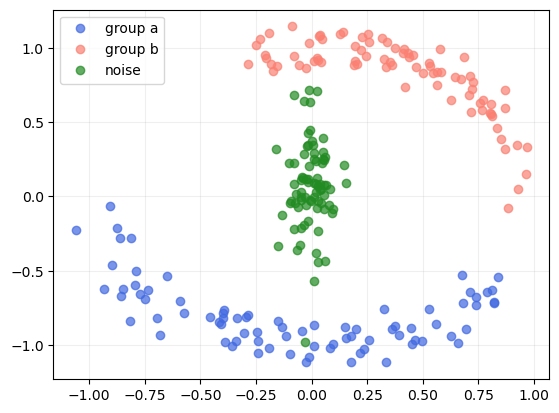

In [8]:
fig, ax = plt.subplots()
ax.plot(a_group[:,0],a_group[:,1],'o',color='royalblue',alpha=0.7,label='group a')
ax.plot(b_group[:,0],b_group[:,1],'o',color='salmon',alpha=0.7,label='group b')
ax.plot(gaussian_noise[:,0], gaussian_noise[:,1],'o', color='forestgreen',alpha=0.7,label='noise')
ax.grid(alpha=0.2)
ax.legend()

In [9]:
whole_data = np.vstack((a_group,b_group,gaussian_noise))

In [10]:
kmeans_boundaries = KMeans(n_clusters=3).fit(X=whole_data)

In [11]:
xx, yy = np.meshgrid(np.linspace(-1.2,1.2,200), np.linspace(-1.2,1.2,200))
results_plot = np.empty(200**2)
for i in tqdm(range(200**2)):
    results_plot[i] = kmeans_boundaries.predict(np.c_[xx.ravel(), yy.ravel()][i,:].reshape(1,-1))[0]
Z = results_plot
Z = Z.reshape(xx.shape)

100%|██████████| 40000/40000 [00:14<00:00, 2795.04it/s]


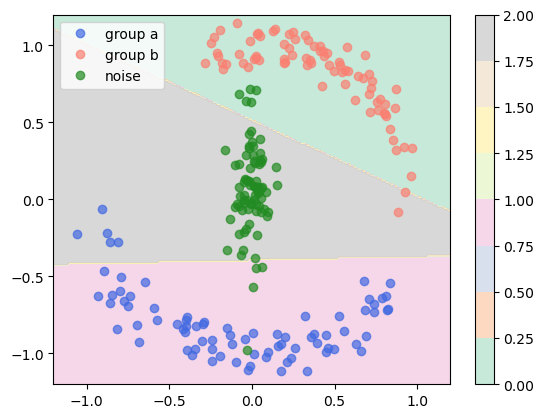

In [12]:
plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.Pastel2)
plt.plot(a_group[:,0],a_group[:,1],'o',color='royalblue',alpha=0.7,label='group a')
plt.plot(b_group[:,0],b_group[:,1],'o',color='salmon',alpha=0.7,label='group b')
plt.plot(gaussian_noise[:,0], gaussian_noise[:,1],'o', color='forestgreen',alpha=0.7,label='noise')
plt.legend()
plt.colorbar()
plt.show()

We have to find the solutions of the following Wolfe Lagrangian : 

$$W = \sum_{j}K(x_j,x_j)\beta_j - \sum_{i,j}K(x_i,x_j)\beta_i\beta_j$$

In order to use a quadratic solver, we have to rewrite a little bit the above problem. 

Let's denote by $K_{diag}$ the vector containing only the diagonal elements of the Gram matrix K. We denote by $\beta$ the vector which has entries $\{\beta_i\}_{i=1}^n$, moreover, we denote by $\mathbb{1}$ the vector of lentgh $n$ containing only ones.

Hence, we can rewrite the above dual as : 

$$ W = K_{diag}^T \beta - \beta^T K \beta = \mathbb{1} - \beta^T K \beta $$

$$ \text{s.t.} 0\leq \beta_j \leq C $$
$$ \sum_j^n \beta_j = 1 $$

In [13]:
#to find an adequate q for the width of the kernel
norms_q = np.linalg.norm(whole_data, axis=1)**2
dot_q = whole_data@whole_data.T
squared_euclidian_distances_q = norms_q[:, None] - 2 * dot_q + norms_q[None, :]

In [14]:
bandwidth = 1/(np.max(squared_euclidian_distances_q))
#gram_x = gram_mat(X=whole_data,q=bandwidth)
gram_x = gram_mat(X=whole_data,q=48)

In [15]:
beta = cp.Variable(n)
gram_x += gram_x.T
gram_x /= 2
gram_x = cp.psd_wrap(gram_x)


# Formulation de l'objectif
objective = cp.Maximize(cp.sum(np.ones(n) @ beta) - cp.quad_form(beta, gram_x))

# Contraintes
constraints = [
    beta >= 0,  # 0 <= beta_j
    beta <= C,  # beta_j <= C
    cp.sum(beta) == 1  # La somme des éléments de beta doit être égale à 1
]

# Définir le problème d'optimisation
problem = cp.Problem(objective, constraints)

# Résoudre le problème
problem.solve()

np.float64(0.9752720425342833)

In [16]:
true_beta = beta.value

In [17]:
index_of_sv = list(np.where(true_beta>1e-10)[0])

In [18]:
potential_sv = whole_data[index_of_sv,:]

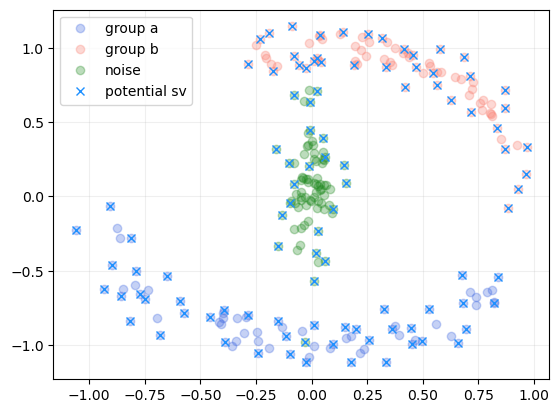

In [19]:
fig, ax = plt.subplots()
ax.plot(a_group[:,0],a_group[:,1],'o',color='royalblue',alpha=0.3,label='group a')
ax.plot(b_group[:,0],b_group[:,1],'o',color='salmon',alpha=0.3,label='group b')
ax.plot(gaussian_noise[:,0], gaussian_noise[:,1],'o', color='forestgreen',alpha=0.3,label='noise')
ax.plot(potential_sv[:,0], potential_sv[:,1],'x',color='dodgerblue',label='potential sv')
ax.grid(alpha=0.2)
ax.legend()

In [20]:
for i in range(n):
    if true_beta[i] < 1e-10:
        true_beta[i] = 0

In [44]:
del gram_x
gram_x = gram_mat(X=whole_data,q=48)
gram_x += gram_x.T
gram_x /= 2
r = []
beta_k_beta = true_beta.T@gram_x@true_beta
for i in potential_sv:
    temp_K = np.zeros(n)
    for elem in range(n):
        temp_K[elem] = gaussian_ker(i,whole_data[elem,:],q=48)
    r_xi = np.sqrt(1 - 2*np.dot(temp_K, true_beta) + beta_k_beta)
    r.append(r_xi)
rad = max(r)

In [45]:
adjacency_mat = np.zeros((n,n))
for i in tqdm(range(n)):
    for j in range(i,n):
        decision = True
        segment = compute_seg(x=whole_data[i,:], y=whole_data[j,:])
        list_of_val = []
        for point in segment:
            dist = radius(x=point,beta=true_beta,bkb=beta_k_beta,sample=whole_data)
            list_of_val.append(dist)
        for value in list_of_val:
            if value > rad:
                decision = False
        
        if decision == True:
            adjacency_mat[i,j] = 1
        

100%|██████████| 240/240 [11:25<00:00,  2.86s/it]


In [47]:
adjacency_mat = adjacency_mat + adjacency_mat.T
adjacency_mat /= 2
for i in range(n):
    adjacency_mat[i,i] = 0

In [48]:
import networkx as nx
G = nx.from_numpy_array(adjacency_mat)

In [49]:
clusters = list(nx.connected_components(G))
clusters

[{0, 1, 2, 3, 4},
 {5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20},
 {19,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  73,
  206},
 {69, 70, 71, 72, 74, 75, 76, 77, 78, 79},
 {80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  164,
  169,
  219,
  226,
  238},
 {158, 159}

In [35]:
whole_data[8]

array([-0.79482045, -0.59171705])

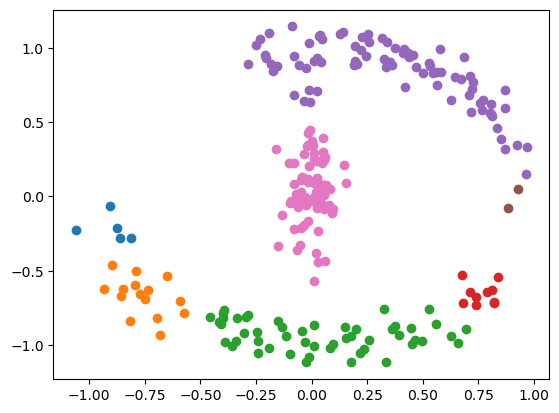

In [50]:
plt.figure()
for cluster in clusters:
    points_cluster = np.array([whole_data[index] for index in cluster])
    plt.scatter(points_cluster[:, 0], points_cluster[:, 1])
plt.show()

Application on the iris dataset